## Data analysis code for gain=5000 data taken on 09/04/2025. Binning 1x1
Used for scanning frequency on solid target. 

In [31]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfiltfilt, sosfreqz

## Define functions for Gaussian fitting

In [32]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [33]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

In [34]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\09\05'

# Define PC thresholds for binning=1x1, EMCCD gain=5000

Text(0, 0.5, 'Number of Pixels')

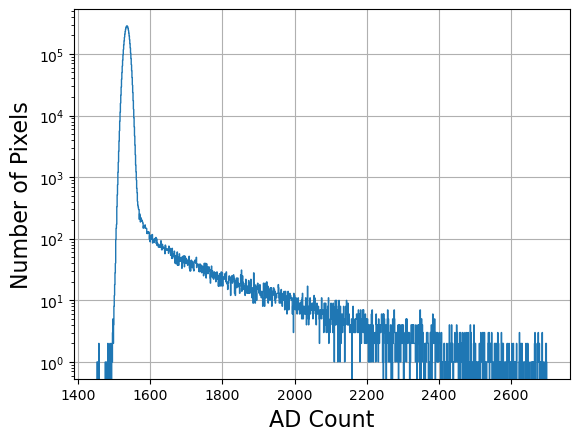

In [35]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0000'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[6.36167143e-02 7.00000000e+00 1.53500000e+03]
[69, 99, 1513, 1557, 1480, 1900]
fit region: AD count =  1520 to  1549
Fit Converged
Converged with chi-squared 148.543590846093
Number of degrees of freedom, dof = 27
Reduced chi-squared 5.501614475781222
Inital guess values:
  p0 = [0.06361671429973197, 7, 1535]
Best fit values:
  pf = [0.06621822438892556, 7.2877945303383616, 1535.6520315592147]
Uncertainties in the best fit values:
  pferr = [3.0432677881976988e-05, 0.0035011560017188166, 0.003701909413897596]
5 sigma threshold is 1572.0910042109065 with uncertainty 0.02120768942249168


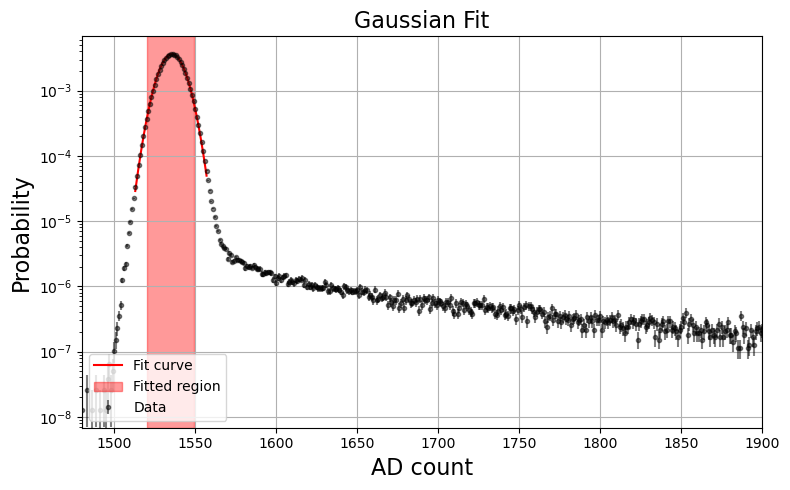

In [36]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1520
End_gaussian=1550

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1572

In [37]:
LIF_thres=1572

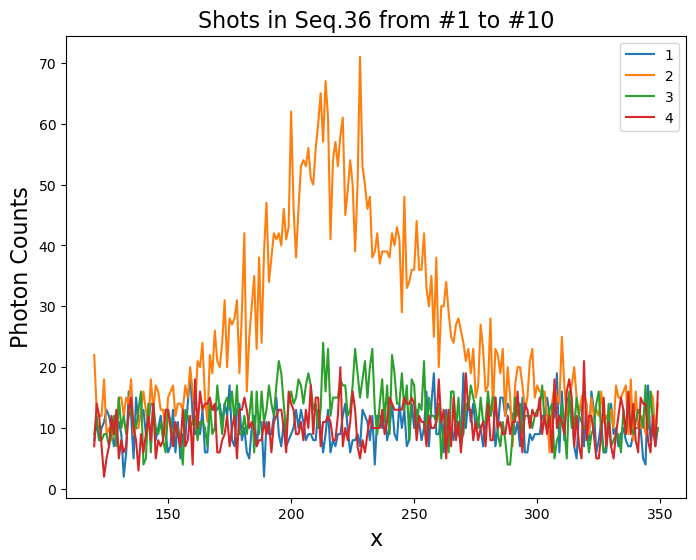

total # of photons =  13638
total_counts= 4
average # of photons =  3409.5


In [8]:
# Photon counts for each of the shots
seq = 36 #sequence number
count_b_start=1
count_b_end=10

folder_path = folder_path_day + '\\%.4i'%seq
sum_array=[] #average number of photons
fig = plt.figure(20, figsize=(8,6))
total_counts=0
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<LIF_thres]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            
            plt.plot(np.arange(120,350,1),cross_section_x[120:350], label=count_b)
            sum_array.append(np.sum(cross_section_x[120:350]))
            total_counts+=1


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print("total # of photons = ", np.sum(sum_array))
print("total_counts=", total_counts)
print("average # of photons = ", np.sum(sum_array)/total_counts)


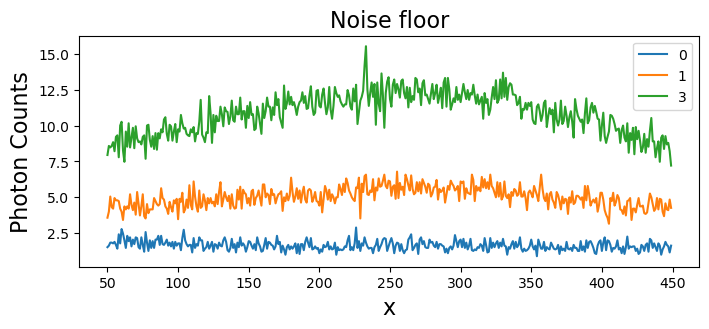

In [18]:

LIF_thres=1572
fig = plt.figure(20, figsize=(8,3))
plot_range=np.arange(50,450,1)
for seq in np.array([0,1,3]):
    folder_path = folder_path_day + '\\%.4i'%seq
    photon_array=[] #average number of photons
    freq_array=[]
    cross_section_x_tot=None
    count=0
    
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        if not count_b==0:
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<LIF_thres]=0
                cross_section_x = np.count_nonzero(image_data, axis=0)
                if cross_section_x_tot is None:
                    cross_section_x_tot = np.zeros_like(cross_section_x, dtype=np.float64)
                cross_section_x_tot += cross_section_x 
            count+=1
    
    
    cross_section_x_tot = cross_section_x_tot/count
    plt.plot(plot_range,cross_section_x_tot[plot_range], label=seq)

plt.xlabel('x', fontsize=16)
# plt.ylim([0,500])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Noise floor', fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

# FM absorption signal

In [19]:
def line_func(x, A, B):
    return B
    #return A*x + B
def smooth(data,window=5,poly_order=3):
    '''Function for smoothing data. Currently uses Savitzky-Golay filter,
    which fits a window of data onto a polynomial of some order, and then
    uses the polynomial to estimate the value'''
    #window value must be odd
    if window % 2 == 0:
        window+=1
    smoothed_data = savgol_filter(data, window, poly_order)
    return smoothed_data

def butter_lowpass_filter(data, lowcut, fs, order=5):
    sos = butter_lowpass(lowcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    sos = butter(order, low, analog=False, btype='lowpass', output='sos')
    return sos

C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_14896\3789374924.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])


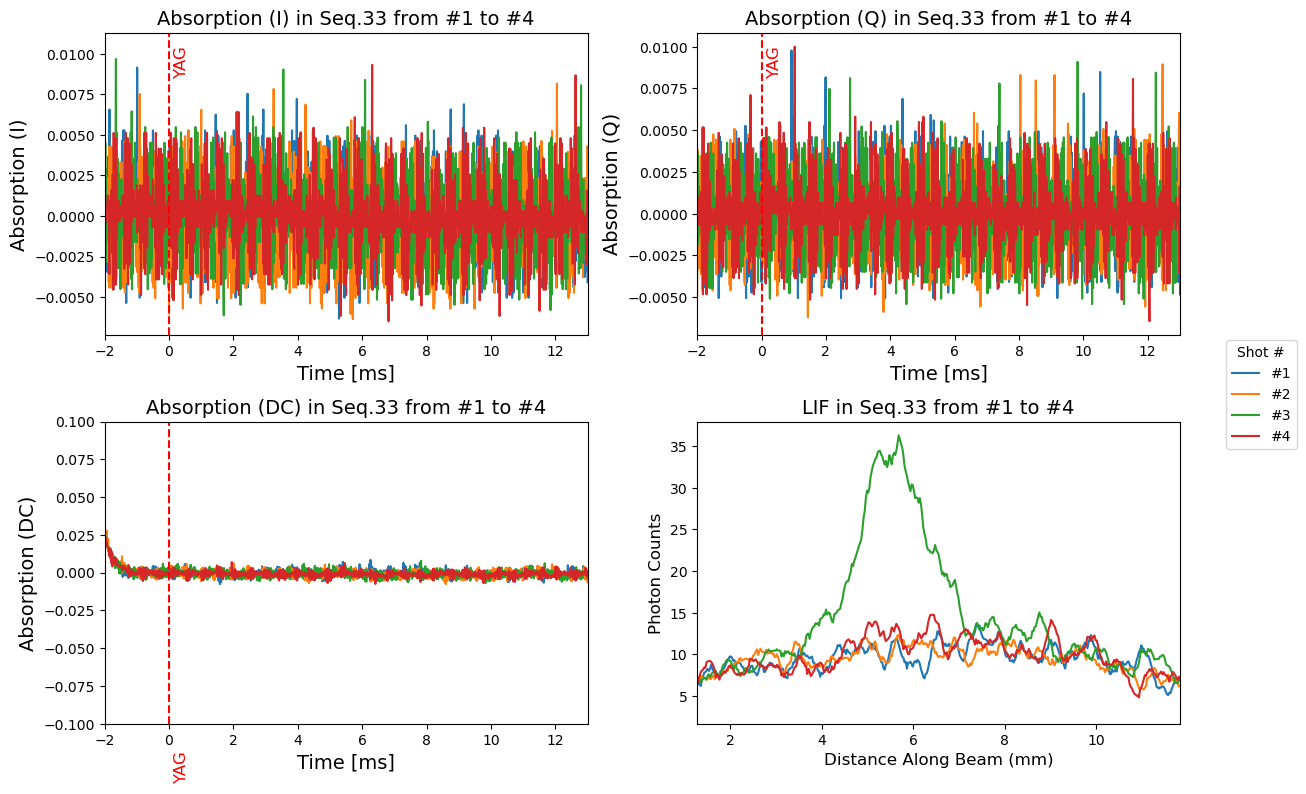

In [30]:
seq =33 #sequence number
LIF_range=np.arange(1,512,1)
photon_counting_threshold=1572
DC_ylim=[-0.1, 0.1] #for plot 3


folder_path = folder_path_day + r'/%.4i'%seq

plt.close()

# smooth_method = 'no filter'
# smooth_method = 'lowpass'
smooth_method = 'savgol'
# smooth_method = 'both'

count_b_start=1
count_b_end=20

abs_sums=[]
fluor_sums = []
tYAG=2

# LIF
conversion = 0.016*8/5 #EMCCD pixel size=0.016mm and optical magnification=8/5 on FOV

# Setup subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Unpack individual axes
ax_abs1 = axes[0, 0]
ax_abs2 = axes[0, 1]
ax_abs3 = axes[1, 0]
ax_lif  = axes[1, 1]
abs_traces = ['Absorption', 'Absorption2', 'Absorption3']
abs_axes = [ax_abs1, ax_abs2, ax_abs3] 
abs_labels = ['Absorption (I)', 'Absorption (Q)', 'Absorption (DC)']

last_file = ''
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        if os.path.exists(file_path):
            last_file = count_b
            pass
        else:
            continue
        with h5py.File(file_path, 'r') as file:
            ## Absorption ############
            for i, (trace_name, ax_abs) in enumerate(zip(abs_traces, abs_axes)):
                analog_data = file[f'data/traces/{trace_name}'][:]
                times, values = zip(*analog_data)
                # Convert to NumPy arrays if needed
                time_ms = np.array(times)*1000
                values = np.array(values)
    
                #collect useful indices. Could have also done times.searchsorted()
                trigger_index = np.searchsorted(time_ms,tYAG)
                beforeYAG_index = np.searchsorted(time_ms,1.95) # hardcoded values are on the absorption data timeframe.
                after_abs_index = np.searchsorted(time_ms,10)
                end_index = np.searchsorted(time_ms,15)
            
                #Remove linear drift and find offset 
                fit_time = np.concatenate((time_ms[:beforeYAG_index],time_ms[after_abs_index:end_index]))
                fit_data = np.concatenate((values[:beforeYAG_index],values[after_abs_index:end_index]))
                popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])
                slope=popt[0]
                intercept=popt[1]
                flat_data =  values - line_func(time_ms,slope,intercept)
                offset = flat_data[:trigger_index].mean()
    
                #Plot on absorption subplot
                ax_abs.plot(time_ms-tYAG, flat_data, label=f'#{count_b}')
        
                #Sum of absorption signals
                dt=(time_ms[1]-time_ms[0])
                abs_sum = np.sum(abs(flat_data[time_ms.searchsorted(tYAG+0.05):time_ms.searchsorted(tYAG+6)]))*dt
                # -------- PLOT FORMATTING --------
                ax_abs.set_title(f'{abs_labels[i]} in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
                ax_abs.set_xlabel('Time [ms]', fontsize=14)
                ax_abs.set_ylabel(abs_labels[i], fontsize=14)
                # ax_abs.legend(fontsize=8)
                # ----------------------------------
            ####################################


            
            ## LIF ########################
            # get x-cross section for every shot in the sequence
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<photon_counting_threshold]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            cross_section_x=cross_section_x[LIF_range]

            filter_freq = 0.05
            if smooth_method == 'lowpass': #Smoothing with lowpass filter
                N = len(LIF_range)
                delta_s = (LIF_range[1]-LIF_range[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filtered_data = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
            elif smooth_method == 'savgol': #Smoothing with polynomial filter
                filtered_data = smooth(cross_section_x,window=20,poly_order=3)
            elif smooth_method == 'both': #Smoothing with both filters
                N = len(LIF_range)
                delta_s = (LIF_range[1]-LIF_range[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filt1 = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
                filt2 = smooth(cross_section_x,window=25,poly_order=3)
                filtered_data = np.array([filt1,filt2]).T
            else: # No filter
                filtered_data = cross_section_x
                
            #Plot on LIF subplot
            pixel_mm = LIF_range * conversion
            ax_lif.plot(pixel_mm, filtered_data, label=f'#{count_b}')

            # #Sum of LIF signals
            # ADC_base = filtered_data[0:50].mean()
            # fluor_sum = np.sum((filtered_data[x.searchsorted(3.5/conversion):x.searchsorted(8.5/conversion)]-ADC_base))
            # abs_sums.append(abs_sum)
            # fluor_sums.append(fluor_sum)
            ####################################




# -------- PLOT FORMATTING --------
# Absorption Plot
for ax_abs in abs_axes:
    ax_abs.axvline(x=0, color='r', linestyle='--')
    ax_abs.text(0.4, ax_abs.get_ylim()[1] * 0.85 + ax_abs.get_ylim()[0] * 0.15, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    x_range = (0 - tYAG, 15 - tYAG)
    ax_abs.set_xlim(x_range[0], x_range[1])
    if ax_abs == ax_abs3:
        ax_abs.set_ylim(DC_ylim) 
        for txt in ax_abs.texts:
            txt.remove()
        ax_abs.text(0.4, -1.5 * 0.15 + ax_abs.get_ylim()[1] * 0.85, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')


## legend, comment ouf if you don't need ###
# --- Collect legend handles and labels from all axes ---
handles = []
labels = []
for ax in abs_axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
# Remove duplicates
legend_dict = dict(zip(labels, handles))
unique_labels = list(legend_dict.keys())
unique_handles = list(legend_dict.values())
# --- Add global legend to the figure ---
fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title='Shot #')
####################################

# LIF Plot
ax_lif.set_title(f'LIF in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
ax_lif.set_xlabel('Distance Along Beam (mm)', fontsize=12)
ax_lif.set_ylabel('Photon Counts', fontsize=12)
ax_lif.set_xlim(0 + 50 * conversion, (512 - 50) * conversion)

plt.tight_layout(rect=[0, 0, 1, 1])

# ----------------------------------


# # -------- ABS vs LIF CORRELATION --------
# plt.figure(3)
# abs_sums = np.array(abs_sums).T
# plt.plot(abs_sums,fluor_sums,'ko',label='all abs')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('FM Cell Signal, Ba', fontsize=14)
# plt.ylabel('LIF Beam Signal, BaF', fontsize=14)
# plt.title('Correlation between Abs and LIF signals', fontsize=14)

plt.show()

# Define PC thresholds for binning=4x4, EMCCD gain=5000

Text(0, 0.5, 'Number of Pixels')

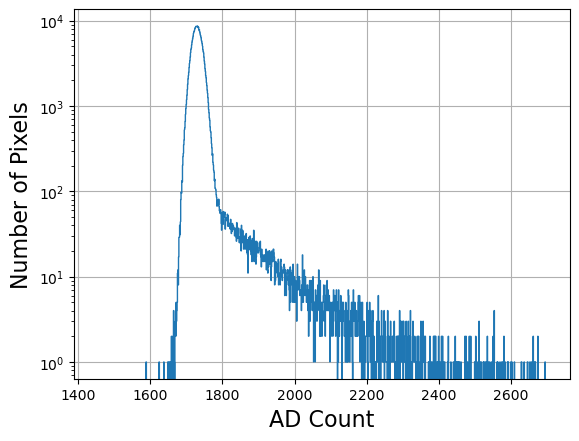

In [21]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 128, 128), np.NaN)
folder_path = folder_path_day + '\\0006'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[3.10467576e-02 7.00000000e+00 1.73100000e+03]
[249, 309, 1693, 1767, 1480, 1900]
fit region: AD count =  1700 to  1759
Fit Converged
Converged with chi-squared 198.23521380173148
Number of degrees of freedom, dof = 57
Reduced chi-squared 3.4778107684514294
Inital guess values:
  p0 = [0.03104675755437432, 7, 1731]
Best fit values:
  pf = [0.06472054426952747, 14.775603713050554, 1729.8915829515404]
Uncertainties in the best fit values:
  pferr = [0.00012044301431396332, 0.02910258871839434, 0.030257665243542793]
5 sigma threshold is 1803.769601516793 with uncertainty 0.17577060883551449


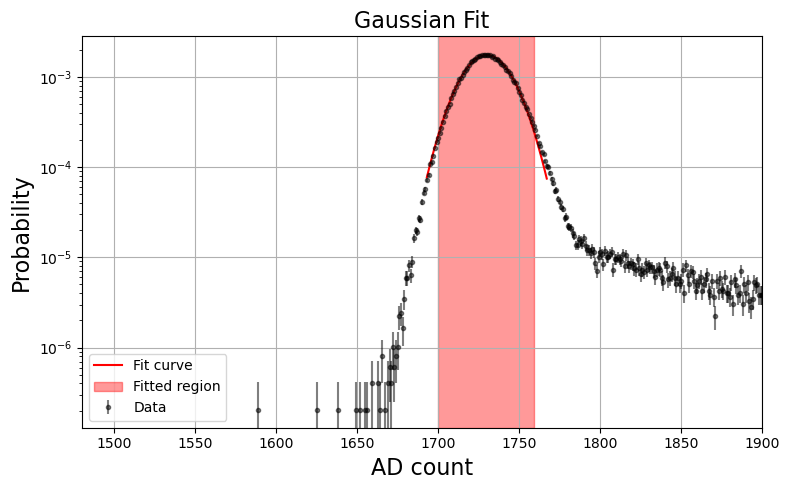

In [22]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1700
End_gaussian=1760

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1804

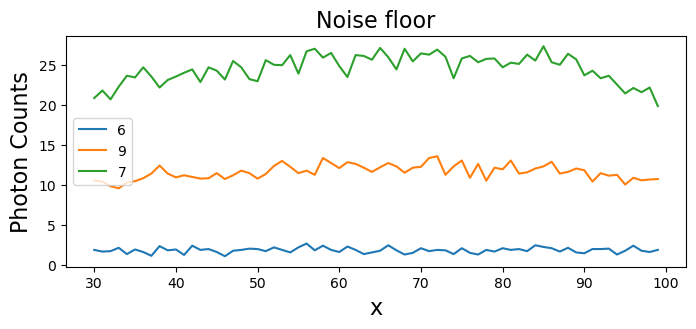

In [28]:
## get averaged background 50mW noise
LIF_thres=1804
fig = plt.figure(20, figsize=(8,3))
plot_range=np.arange(30,100,1)
for seq in np.array([6, 9, 7]):
    folder_path = folder_path_day + '\\%.4i'%seq
    photon_array=[] #average number of photons
    freq_array=[]
    cross_section_x_tot=None
    count=0
    
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        if not count_b==0:
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<LIF_thres]=0
                cross_section_x = np.count_nonzero(image_data, axis=0)
                if cross_section_x_tot is None:
                    cross_section_x_tot = np.zeros_like(cross_section_x, dtype=np.float64)
                cross_section_x_tot += cross_section_x 
            count+=1
    
    
    cross_section_x_tot = cross_section_x_tot/count
    plt.plot(plot_range,cross_section_x_tot[plot_range], label=seq)

plt.xlabel('x', fontsize=16)
# plt.ylim([0,500])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Noise floor', fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

NameError: name 'line_func' is not defined

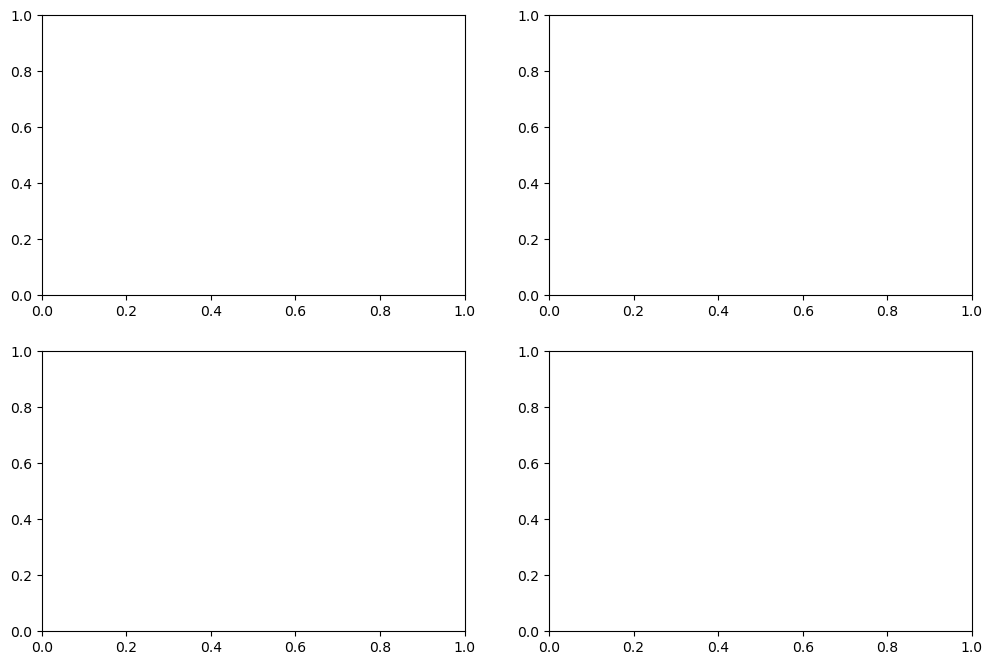

In [13]:
seq =35 #sequence number
LIF_range=np.arange(1,128,1)
photon_counting_threshold=1804
DC_ylim=[-0.1, 0.1] #for plot 3


folder_path = folder_path_day + r'/%.4i'%seq

plt.close()

# smooth_method = 'no filter'
# smooth_method = 'lowpass'
smooth_method = 'savgol'
# smooth_method = 'both'

count_b_start=1
count_b_end=20

abs_sums=[]
fluor_sums = []
tYAG=2

# LIF
conversion = 0.016*8 *4/5 #EMCCD pixel size=0.016mm*4 and optical magnification=8/5 on FOV

# Setup subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Unpack individual axes
ax_abs1 = axes[0, 0]
ax_abs2 = axes[0, 1]
ax_abs3 = axes[1, 0]
ax_lif  = axes[1, 1]
abs_traces = ['Absorption', 'Absorption2', 'Absorption3']
abs_axes = [ax_abs1, ax_abs2, ax_abs3] 
abs_labels = ['Absorption (I)', 'Absorption (Q)', 'Absorption (DC)']

last_file = ''
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        if os.path.exists(file_path):
            last_file = count_b
            pass
        else:
            continue
        with h5py.File(file_path, 'r') as file:
            ## Absorption ############
            for i, (trace_name, ax_abs) in enumerate(zip(abs_traces, abs_axes)):
                analog_data = file[f'data/traces/{trace_name}'][:]
                times, values = zip(*analog_data)
                # Convert to NumPy arrays if needed
                time_ms = np.array(times)*1000
                values = np.array(values)
    
                #collect useful indices. Could have also done times.searchsorted()
                trigger_index = np.searchsorted(time_ms,tYAG)
                beforeYAG_index = np.searchsorted(time_ms,1.95) # hardcoded values are on the absorption data timeframe.
                after_abs_index = np.searchsorted(time_ms,10)
                end_index = np.searchsorted(time_ms,15)
            
                #Remove linear drift and find offset 
                fit_time = np.concatenate((time_ms[:beforeYAG_index],time_ms[after_abs_index:end_index]))
                fit_data = np.concatenate((values[:beforeYAG_index],values[after_abs_index:end_index]))
                popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])
                slope=popt[0]
                intercept=popt[1]
                flat_data =  values - line_func(time_ms,slope,intercept)
                offset = flat_data[:trigger_index].mean()
    
                #Plot on absorption subplot
                ax_abs.plot(time_ms-tYAG, flat_data, label=f'#{count_b}')
        
                #Sum of absorption signals
                dt=(time_ms[1]-time_ms[0])
                abs_sum = np.sum(abs(flat_data[time_ms.searchsorted(tYAG+0.05):time_ms.searchsorted(tYAG+6)]))*dt
                # -------- PLOT FORMATTING --------
                ax_abs.set_title(f'{abs_labels[i]} in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
                ax_abs.set_xlabel('Time [ms]', fontsize=14)
                ax_abs.set_ylabel(abs_labels[i], fontsize=14)
                # ax_abs.legend(fontsize=8)
                # ----------------------------------
            ####################################


            
            ## LIF ########################
            # get x-cross section for every shot in the sequence
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<photon_counting_threshold]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            cross_section_x=cross_section_x[LIF_range]

            filter_freq = 0.05
            if smooth_method == 'lowpass': #Smoothing with lowpass filter
                N = len(LIF_range)
                delta_s = (LIF_range[1]-LIF_range[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filtered_data = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
            elif smooth_method == 'savgol': #Smoothing with polynomial filter
                filtered_data = smooth(cross_section_x,window=20,poly_order=3)
            elif smooth_method == 'both': #Smoothing with both filters
                N = len(LIF_range)
                delta_s = (LIF_range[1]-LIF_range[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filt1 = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
                filt2 = smooth(cross_section_x,window=25,poly_order=3)
                filtered_data = np.array([filt1,filt2]).T
            else: # No filter
                filtered_data = cross_section_x
                
            #Plot on LIF subplot
            pixel_mm = LIF_range * conversion
            ax_lif.plot(pixel_mm, filtered_data, label=f'#{count_b}')

            # #Sum of LIF signals
            # ADC_base = filtered_data[0:50].mean()
            # fluor_sum = np.sum((filtered_data[x.searchsorted(3.5/conversion):x.searchsorted(8.5/conversion)]-ADC_base))
            # abs_sums.append(abs_sum)
            # fluor_sums.append(fluor_sum)
            ####################################




# -------- PLOT FORMATTING --------
# Absorption Plot
for ax_abs in abs_axes:
    ax_abs.axvline(x=0, color='r', linestyle='--')
    ax_abs.text(0.4, ax_abs.get_ylim()[1] * 0.85 + ax_abs.get_ylim()[0] * 0.15, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    x_range = (0 - tYAG, 15 - tYAG)
    ax_abs.set_xlim(x_range[0], x_range[1])
    if ax_abs == ax_abs3:
        ax_abs.set_ylim(DC_ylim) 
        for txt in ax_abs.texts:
            txt.remove()
        ax_abs.text(0.4, -1.5 * 0.15 + ax_abs.get_ylim()[1] * 0.85, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')


## legend, comment ouf if you don't need ###
# --- Collect legend handles and labels from all axes ---
handles = []
labels = []
for ax in abs_axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
# Remove duplicates
legend_dict = dict(zip(labels, handles))
unique_labels = list(legend_dict.keys())
unique_handles = list(legend_dict.values())
# --- Add global legend to the figure ---
fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title='Shot #')
####################################

# LIF Plot
ax_lif.set_title(f'LIF in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
ax_lif.set_xlabel('Distance Along Beam (mm)', fontsize=12)
ax_lif.set_ylabel('Photon Counts', fontsize=12)
ax_lif.set_xlim(0 + 10 * conversion, (128 - 10) * conversion)

plt.tight_layout(rect=[0, 0, 1, 1])

# ----------------------------------


# # -------- ABS vs LIF CORRELATION --------
# plt.figure(3)
# abs_sums = np.array(abs_sums).T
# plt.plot(abs_sums,fluor_sums,'ko',label='all abs')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('FM Cell Signal, Ba', fontsize=14)
# plt.ylabel('LIF Beam Signal, BaF', fontsize=14)
# plt.title('Correlation between Abs and LIF signals', fontsize=14)

plt.show()